# Project 2
Group members: Lena Jörg, Sigurd Kolltveit, Gregor Moe

Boris method implementaion

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp

In [ ]:
def boris_step(x, v_half, h, B, gradU):
    v_minus = v_half - 0.5 * h * gradU(x)

    t = 0.5 * h * B(x)
    t_mag2 = np.dot(t, t)

    v_prime = v_minus + np.cross(v_minus, t)
    s = 2 * t / (1 + t_mag2)

    v_plus = v_minus + np.cross(v_prime, s)
    v_half_next = v_plus - 0.5 * h * gradU(x)

    x_next = x + h * v_half_next
    return x_next, v_half_next


In [ ]:
def initialize_v_half(x0, v0, h, B, gradU):
    def rhs(t, y):
        x, v = y[:3], y[3:]
        return np.concatenate([v, np.cross(v, B(x)) - gradU(x)])
    
    sol = solve_ivp(rhs, [0, -h/2], np.concatenate([x0, v0]), rtol=1e-10, atol=1e-12)
    return sol.y[3:, -1]


In [ ]:
def boris_integrate(x0, v0, T, h, B, gradU):
    N = int(T/h)
    x = np.zeros((N+1, 3))
    v_half = np.zeros((N+1, 3))

    x[0] = x0
    v_half[0] = initialize_v_half(x0, v0, h, B, gradU)

    for n in range(N):
        x[n+1], v_half[n+1] = boris_step(x[n], v_half[n], h, B, gradU)

    return x, v_half


Model system 3.1 - 2D charged particle

In [ ]:
def B_2D(x):
    x1, x2, x3 = x
    return np.array([0, 0, np.sqrt(x2**2 + x3**2)])

def gradU_2D(x):
    x1, x2, x3 = x
    denom = (x1**2 + x2**2)**1.5
    return np.array([x1/denom, x2/denom, 0]) * (-1/100)

With the initial conditions:

In [ ]:
x0_2D = np.array([0.0, 1.0, 0.1])
v0_2D = np.array([0.09, 0.05, 0.20])

Model system 3.2 - Tokamak

In [ ]:
def B_tokamak(x):
    x1, x2, x3 = x
    r2 = x1**2 + x2**2
    r = np.sqrt(r2)
    return np.array([
        (-2*x2 + x1*x3) / (2*r2),
        ( 2*x1 - x2*x3) / (2*r2),
        (np.sqrt(r2) - 1) / (2*r)
    ])

def gradU_tokamak(x):
    return np.zeros(3)  # U = 0

With initial conditions:

In [ ]:
x0_tok = np.array([1.2, 0.0, 0.0])
v0_tok = np.array([0, 4.816e-4, -2.059e-3])

Plotting the trajectories with boris method for both systems

Converting half-step velocities to integer velocities:

In [ ]:
def v_integer(v_half):
    return 0.5 * (v_half[:-1] + v_half[1:])

In [ ]:
v_2D = v_integer(v_half_2D)
v_tok = v_integer(v_half_tok)

Trajectory plot for system 3.1 (2D charged particle)

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(x_2D[:,0], x_2D[:,1])
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.title("Trajectory in (x₁, x₂) for System 3.1 (Boris)")
plt.axis("equal")
plt.grid(True)
plt.show()

Trajectory plot for system 3.2 (Tokamak)

In [ ]:
R_tok = np.sqrt(x_tok[:,0]**2 + x_tok[:,1]**2)  # Radial distance

plt.figure(figsize=(6,6))
plt.plot(R_tok, x_tok[:,2])
plt.xlabel("R = sqrt(x₁² + x₂²)")
plt.ylabel("x₃")
plt.title("Banana Orbit (Tokamak Field, Boris Method)")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Runge-Kutta 4 implementation

In [ ]:
def rk4_step(v_prev,x_prev,h,f):
    kx1 = h*v_prev
    kv1 = h*f(v_prev,x_prev)

    kx2 = h*(v_prev + kv1/2)
    kv2 = h*f(x_prev + kx1/2, v_prev + kv1/2)

    kx3 = h*(v_prev + kv2/2)
    kv3 = h*f(x_prev + kx2/2, v_prev + kv2/2)

    kx4 = h*(v_prev + kv3)
    kv4 = h*f(x_prev + kx3, v_prev + kv3)

    v = v_prev + (kv1 + 2*kv2 + 2*kv3 + kv4)/6
    x = x_prev + (kx1 + 2*kx2 + 2*kx3 + kx4)/6
    return v, x

def rk4(Tmax,h, v0, x0, B_func, A_func, U_func, gradU_func):
    maxiter = int(Tmax//h)

    vs = np.zeros((maxiter,3))
    xs = np.zeros((maxiter,3))
    vs[0] = v0
    xs[0] = x0
    
    i = 1 
    while i<maxiter: #regner denne iterasjonen
        f = lambda x,v: np.cross(v,B_func(x)) - gradU_func(x)
        vs[i], xs[i] = rk4_step(vs[i-1],xs[i-1],h,f)
        i += 1
    return vs, xs



2D charged particle

In [ ]:
def B_particle(x):
    return np.array([0,0,np.sqrt(x[0]**2+x[1]**2)])

def A_particle(x):
    return np.array([-x[1]*np.sqrt(x[0]**2+x[1]**2), x[0]*np.sqrt(x[0]**2+x[1]**2), 0])/3

def U_particle(x):
    return 1/(100*np.sqrt(x[0]**2 + x[1]**2))

def gradU_particle(x):
    u0 = x[0]/(x[0]**2 + x[1]**2)**(3/2)
    u1 = x[1]/(x[0]**2 + x[1]**2)**(3/2)
    return np.array([u0,u1,0])/(-100)

x0_particle = np.array([0.0,1.0,0.1], dtype=float)
v0_particle = np.array([0.09, 0.05, 0.20], dtype=float) 

In [ ]:
sol = rk4(10**3, .1,v0_particle, x0_particle, B_particle,A_particle,U_particle,gradU_particle)

C:\Users\moeth\AppData\Roaming\Python\Python313\site-packages\numpy\_core\numeric.py:1753: RuntimeWarning: overflow encountered in multiply
  multiply(a1, b2, out=cp0)
C:\Users\moeth\AppData\Roaming\Python\Python313\site-packages\numpy\_core\numeric.py:1757: RuntimeWarning: overflow encountered in multiply
  multiply(a0, b2, out=tmp)
C:\Users\moeth\AppData\Local\Temp\ipykernel_20440\3235457408.py:11: RuntimeWarning: overflow encountered in scalar power
  u0 = x[0]/(x[0]**2 + x[1]**2)**(3/2)
C:\Users\moeth\AppData\Local\Temp\ipykernel_20440\3235457408.py:12: RuntimeWarning: overflow encountered in scalar power
  u1 = x[1]/(x[0]**2 + x[1]**2)**(3/2)
C:\Users\moeth\AppData\Local\Temp\ipykernel_20440\3235457408.py:11: RuntimeWarning: invalid value encountered in scalar divide
  u0 = x[0]/(x[0]**2 + x[1]**2)**(3/2)
C:\Users\moeth\AppData\Local\Temp\ipykernel_20440\3235457408.py:12: RuntimeWarning: invalid value encountered in scalar divide
  u1 = x[1]/(x[0]**2 + x[1]**2)**(3/2)


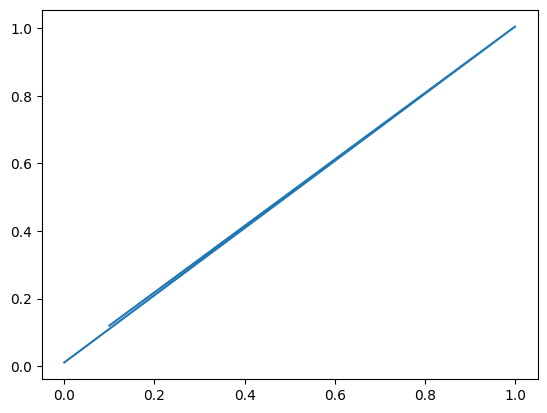

In [ ]:
plt.plot(sol[1][0],sol[1][1])